In [13]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Change working directory to your Colab folder in Drive
os.chdir('/content/drive/MyDrive/colab_files')

print("Current working directory:", os.getcwd())

In [3]:
!pip install -q zeroscratches==1.0.2 "huggingface-hub>=0.22.2"

from huggingface_hub import hf_hub_download

# Create directories for model checkpoints
os.makedirs('checkpoints/restoration/VAE_A_quality', exist_ok=True)
os.makedirs('checkpoints/restoration/VAE_B_scratch', exist_ok=True)
os.makedirs('checkpoints/restoration/mapping_Patch_Attention', exist_ok=True)
os.makedirs('checkpoints/detection', exist_ok=True)

# Download model weight files from Hugging Face (leonelhs/zeroscratches repository)
hf_hub_download(
    repo_id="leonelhs/zeroscratches",
    filename="restoration/VAE_A_quality/latest_net_G.pth",
    local_dir="checkpoints/restoration/VAE_A_quality",
    local_dir_use_symlinks=False
)
hf_hub_download(
    repo_id="leonelhs/zeroscratches",
    filename="restoration/VAE_B_scratch/latest_net_G.pth",
    local_dir="checkpoints/restoration/VAE_B_scratch",
    local_dir_use_symlinks=False
)
hf_hub_download(
    repo_id="leonelhs/zeroscratches",
    filename="restoration/mapping_Patch_Attention/latest_net_mapping_net.pth",
    local_dir="checkpoints/restoration/mapping_Patch_Attention",
    local_dir_use_symlinks=False
)
hf_hub_download(
    repo_id="leonelhs/zeroscratches",
    filename="detection/FT_Epoch_latest.pt",
    local_dir="checkpoints/detection",
    local_dir_use_symlinks=False
)

print("Model weights downloaded and saved in 'checkpoints/' directory.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


latest_net_G.pth:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

latest_net_G.pth:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

latest_net_mapping_net.pth:   0%|          | 0.00/296M [00:00<?, ?B/s]

FT_Epoch_latest.pt:   0%|          | 0.00/452M [00:00<?, ?B/s]

Model weights downloaded and saved in 'checkpoints/' directory.


In [14]:
import glob
import torch
from PIL import Image
import cv2
import numpy as np
from zeroscratches import EraseScratches

# Instantiate the photo restorer (will load the model into memory, using GPU if available)
eraser = EraseScratches()
print("Restoration model loaded (using device:", "CUDA" if torch.cuda.is_available() else "CPU", ")")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Restoration model loaded (using device: CUDA )


In [32]:
def remove_dots(pil_img: Image.Image,
                          kernel=5,
                          thr_black=0, thr_white=0,
                          min_area=6,
                          max_area=300,
                          inpaint_radius=3,
                          circularity=0.4
                          ) -> Image.Image:
    img = np.array(pil_img.convert('RGB'))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    k = np.ones((kernel, kernel), np.uint8)

    bh = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, k)  # тёмные точки
    th = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT,  k)   # светлые точки

    if thr_black == 0:
        _, m_black = cv2.threshold(bh, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        _, m_black = cv2.threshold(bh, thr_black, 255, cv2.THRESH_BINARY)
    if thr_white == 0:
        _, m_white = cv2.threshold(th, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        _, m_white = cv2.threshold(th, thr_white, 255, cv2.THRESH_BINARY)


    def filter_mask(mask):
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        out = np.zeros_like(mask)
        for c in cnts:
            area = cv2.contourArea(c)
            if area < min_area or area > max_area:
                continue
            peri = cv2.arcLength(c, True)
            circ = 0 if peri == 0 else 4*np.pi*area/(peri*peri)
            if circ >= circularity:
                cv2.drawContours(out, [c], -1, 255, -1)
        return out

    m_black = filter_mask(m_black)
    m_white = filter_mask(m_white)

    mask = cv2.bitwise_or(m_black, m_white)
    inpainted = cv2.inpaint(img, mask, inpaint_radius, cv2.INPAINT_TELEA)
    return Image.fromarray(inpainted)

In [33]:
def restore_photo(input_path: str, output_path: str, kernel=5, min_area=6, max_area=220, inpaint_radius=3, circularity=0.45):
    img = Image.open(input_path)

    # базовая реставрация моделью
    restored_arr = eraser.erase(img)
    restored = Image.fromarray(restored_arr)

    # зачистка точек
    cleaned = remove_dots(restored,
                          kernel=kernel,
                          min_area=min_area, max_area=max_area,
                          inpaint_radius=inpaint_radius,
                          circularity=circularity)

    cleaned.save(output_path)

In [17]:
import IPython.display as display

# список путей до фоток
image_paths = sorted(glob.glob('input/*.jpg')) + sorted(glob.glob('input/*.png')) + sorted(glob.glob('input/*.jpeg'))
if len(image_paths) == 0:
    print("No images found in 'input' directory for testing.")

In [18]:
image_paths

['input/photo.jpg', 'input/photo1.jpg', 'input/photo2.jpg']

Testing on image: photo1.jpg


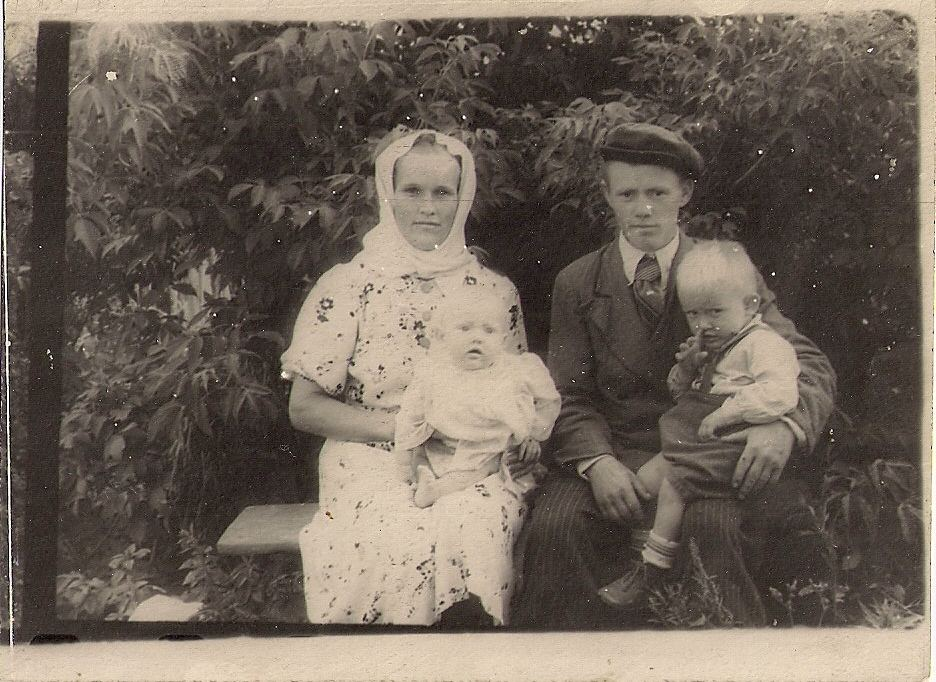

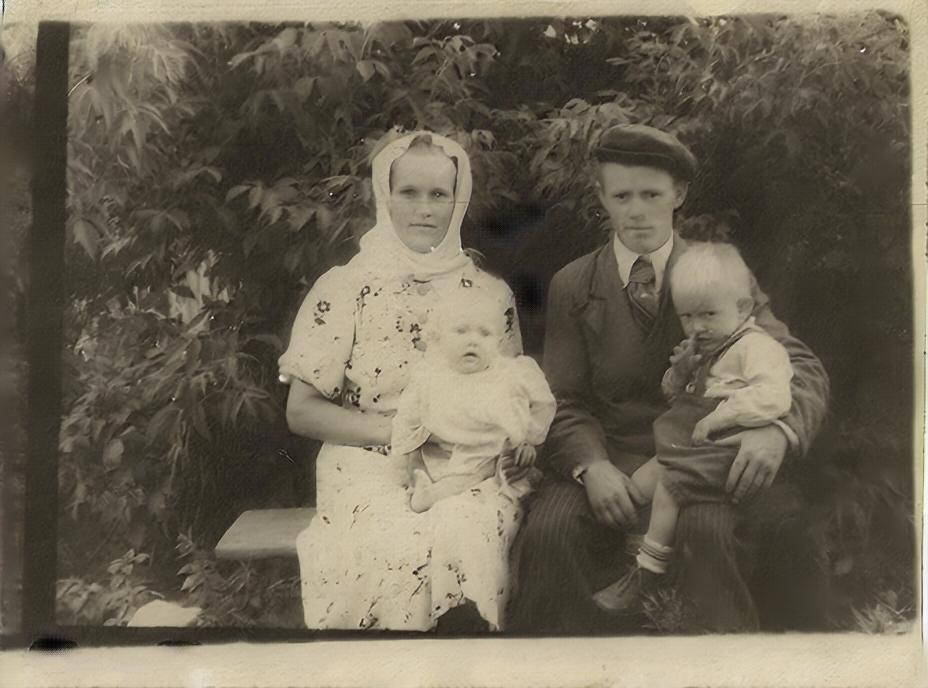

In [49]:
kernel = 6 # чем больше - агрессивнее поиск точек
min_area = 3 # мин размер точки
max_area = 220 # макс размер точки
circularity = 0.55 # мера округлости точки
inpaint_radius = 5 # чем больше - сильнее сглаживание вокруг точки


test_image_path = image_paths[1]
print("Testing on image:", os.path.basename(test_image_path))

test_output_path = os.path.join('output', "photo1.jpg")

restore_photo(test_image_path, test_output_path,
                                    kernel=kernel,
                                    min_area=min_area, max_area=max_area,
                                    inpaint_radius=inpaint_radius, circularity=circularity)

orig_img = Image.open(test_image_path)
restored_img = Image.open(test_output_path)

display.display(orig_img, restored_img)

In [ ]:
# Обработка всех фото в директории input

for img_path in image_paths:
    fname = os.path.basename(img_path)
    output_path = os.path.join('output', fname)
    restore_photo(img_path, output_path)

print(f"\nCompleted restoration for {len(input_images)} image(s). Results are saved in the 'output' folder.")